<a href="https://colab.research.google.com/github/isilzulalguner/sentiment-analysis/blob/main/amazon_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch torchvision scikit-learn matplotlib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import bz2

In [ ]:
with bz2.open("/content/test.ft.txt.bz2", "rt") as f:
    test_data = f.readlines()

In [ ]:
# Test veri setini işleme
def process_data(data):
    labels = []
    texts = []
    for line in data:
        labels.append(1 if line[:10].startswith("__label__2") else 0)
        texts.append(line[10:].strip())
    return pd.DataFrame({"text": texts, "label": labels})

test_df = process_data(test_data)

In [ ]:
with bz2.open("/content/train.ft.txt.bz2", "rt") as f:
    train_data = [next(f) for _ in range(10000)]  # İlk 10,000 satırı oku

In [ ]:
train_df = process_data(train_data)

In [ ]:
# Veri bölme
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["text"], train_df["label"], test_size=0.2, random_state=42
)

In [ ]:
# Base Model 1: Support Vector Machine
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(train_texts)
X_val_tfidf = vectorizer.transform(val_texts)

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, train_labels)

svm_predictions = svm_model.predict(X_val_tfidf)
svm_accuracy = accuracy_score(val_labels, svm_predictions)
print("SVM Accuracy:", svm_accuracy)
print(classification_report(val_labels, svm_predictions))

SVM Accuracy: 0.869
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1037
           1       0.87      0.86      0.86       963

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



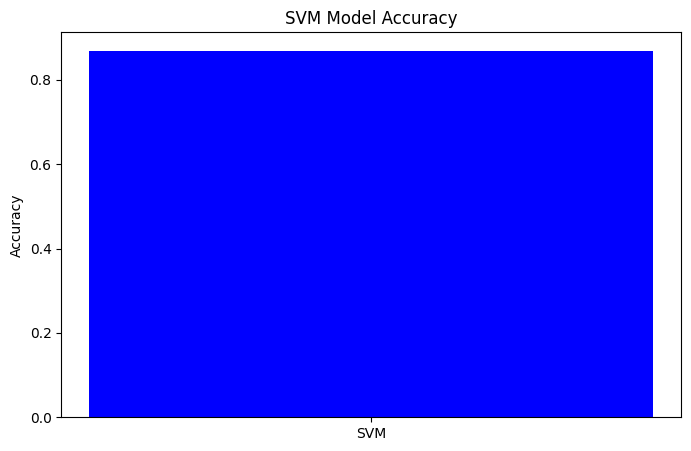

In [ ]:
# Grafik: SVM Sonuçları
plt.figure(figsize=(8, 5))
plt.bar(["SVM"], [svm_accuracy], color='blue')
plt.title("SVM Model Accuracy")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Base Model 2: RNN
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_texts)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(train_texts), maxlen=max_len)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(val_texts), maxlen=max_len)

rnn_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dense(1, activation="sigmoid")
])

rnn_model.compile(optimizer=Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["accuracy"])
history = rnn_model.fit(X_train_seq, train_labels, validation_data=(X_val_seq, val_labels), epochs=5, batch_size=64)
rnn_eval = rnn_model.evaluate(X_val_seq, val_labels)
rnn_accuracy = rnn_eval[1]
print("RNN Accuracy:", rnn_accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6301 - loss: 0.5982 - val_accuracy: 0.8460 - val_loss: 0.3699
Epoch 2/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9161 - loss: 0.2406 - val_accuracy: 0.8560 - val_loss: 0.3541
Epoch 3/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9523 - loss: 0.1391 - val_accuracy: 0.8510 - val_loss: 0.4009
Epoch 4/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9826 - loss: 0.0662 - val_accuracy: 0.8490 - val_loss: 0.5028
Epoch 5/5
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9823 - loss: 0.0582 - val_accuracy: 0.8370 - val_loss: 0.5996
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8358 - loss: 0.6061
RNN Accuracy: 0.8370000123977661


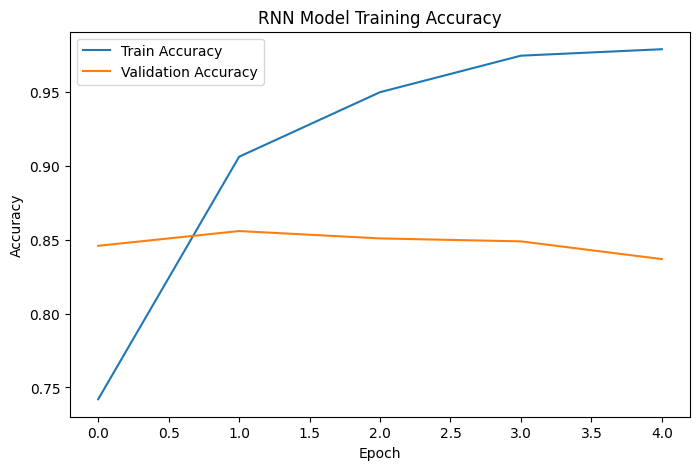

In [ ]:
# Grafik: RNN
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("RNN Model Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from torch.utils.data import Dataset

In [ ]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)


In [ ]:
print(train_df.loc[0])  # İlk satıra erişmeyi dener
print(train_df.loc[len(train_df) - 1])  # Son satıra erişmeyi dener


text     Stuning even for the non-gamer: This sound tra...
label                                                    1
Name: 0, dtype: object
text     Beautiful Pen and Fast Delivery.: The pen was ...
label                                                    1
Name: 9999, dtype: object


In [ ]:
# İndeksleri sıfırla
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Sütunları ve indeksleri doğrula
print("Train DataFrame Columns:", train_df.columns)
print("Test DataFrame Columns:", test_df.columns)
print("Train DataFrame Shape:", train_df.shape)
print("Test DataFrame Shape:", test_df.shape)


Train DataFrame Columns: Index(['text', 'label'], dtype='object')
Test DataFrame Columns: Index(['text', 'label'], dtype='object')
Train DataFrame Shape: (10000, 2)
Test DataFrame Shape: (400000, 2)


In [ ]:
!pip install torch

In [ ]:
!pip install --upgrade torch

In [ ]:
# İndeksleri sıfırlama
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Veri bölme işlemi
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["text"].to_numpy(), train_df["label"].to_numpy(), test_size=0.2, random_state=42
)

# Hatalı indekslerin kontrolü
print("Train DataFrame Shape:", train_df.shape)
print("Validation Data Indices:", len(val_texts))

# Advanced Model: BERT
class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item

# Tokenizer ve Dataset oluşturma
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def encode_data(texts, labels, tokenizer, max_length=128):
    encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors="pt")
    return encodings, labels

train_encodings, train_labels = encode_data(train_texts, train_labels, tokenizer)
val_encodings, val_labels = encode_data(val_texts, val_labels, tokenizer)

torch_train_dataset = CustomDataset(train_encodings, train_labels)
torch_val_dataset = CustomDataset(val_encodings, val_labels)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, predictions)
    return {"eval_accuracy": accuracy}

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    learning_rate=2e-5,
    gradient_accumulation_steps=2,
    fp16=True,
    report_to=["none"]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=torch_train_dataset,
    eval_dataset=torch_val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)
bert_accuracy = eval_results.get('eval_accuracy')
print("BERT Evaluation Accuracy:", bert_accuracy)

Train DataFrame Shape: (10000, 2)
Validation Data Indices: 2000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.378900,0.195277,0.929500
2,0.206900,0.186500,0.931000
3,0.147400,0.258002,0.931500


Evaluation Results: {'eval_accuracy': 0.9315, 'eval_loss': 0.2580016851425171, 'eval_runtime': 3.5822, 'eval_samples_per_second': 558.315, 'eval_steps_per_second': 17.587, 'epoch': 3.0}
BERT Evaluation Accuracy: 0.9315


In [ ]:
!pip install matplotlib

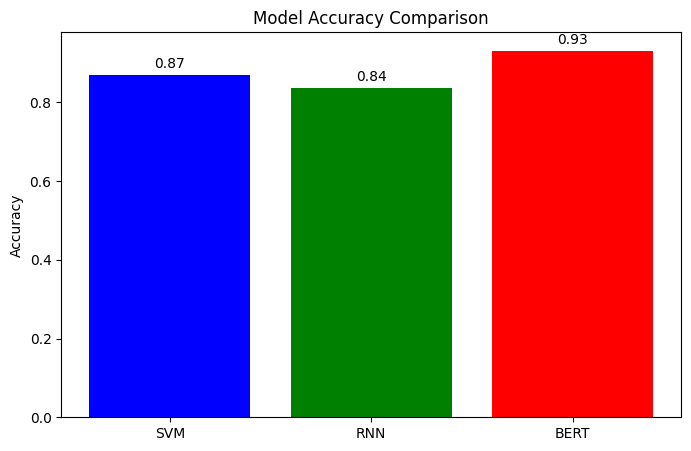

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.bar(["SVM", "RNN", "BERT"], [0.869, 0.8370000123977661, 0.9315], color=['blue', 'green', 'red'])
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")

accuracies = [0.869, 0.8370000123977661, 0.9315]
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center', va='bottom')

plt.show()
